<a href="https://colab.research.google.com/github/sspaulc/TAXI-MOBILITY-SURGE-PRICE-PREDICTION/blob/main/Taxi_Price_Surge_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data provided by an Indian cab aggregator service Sigma Cabs. Their customers can download their app on smartphones and book a cab from anywhere in the cities they operate in. They, in turn, search for cabs from various service providers and provide the best option to their clients across available options. They have been in operation for a little less than a year now. During this period, they have captured surge pricing types from the service providers.
The main objective is to build a predictive model, which could help them in predicting the surge pricing type proactively. This would in turn help them in matching the right cabs with the right customers quickly and efficiently.
Trip_ID: ID for TRIP

Trip_Distance: The distance for the trip requested by the customer

TypeofCab: Category of the cab requested by the customer

CustomerSinceMonths: Customer using cab services since n months; 0 month means the current month

LifeStyleIndex: Proprietary index created by Sigma Cabs showing the lifestyle of the customer based on their behaviour

ConfidenceLifeStyle_Index: Category showing confidence on the index mentioned above

Destination_Type: Sigma Cabs divides any destination into one of the 14 categories.

Customer_Rating: Average of lifetime ratings of the customer till date

CancellationLast1Month: Number of trips cancelled by the customer in last 1 month

Var1, Var2 and Var3: Continuous variables masked by the company. Can be used for modelling purposes

Gender: Gender of the customer

SurgePricingType: Target (can be of 3 types) - DV

In [1]:
import numpy as np

import pandas as pd

In [2]:
#Accessing the data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data= pd.read_csv("/content/gdrive/MyDrive/AlmaBetter/Almabetter/Capstone Projects/Taxi Mobility Surge Price Prediction/data_sigma_cabs.csv")

Performing EDA to understand the data better.

In [5]:
import matplotlib.pyplot as plt


In [6]:
#information on null values

import missingno as msno
%matplotlib inline

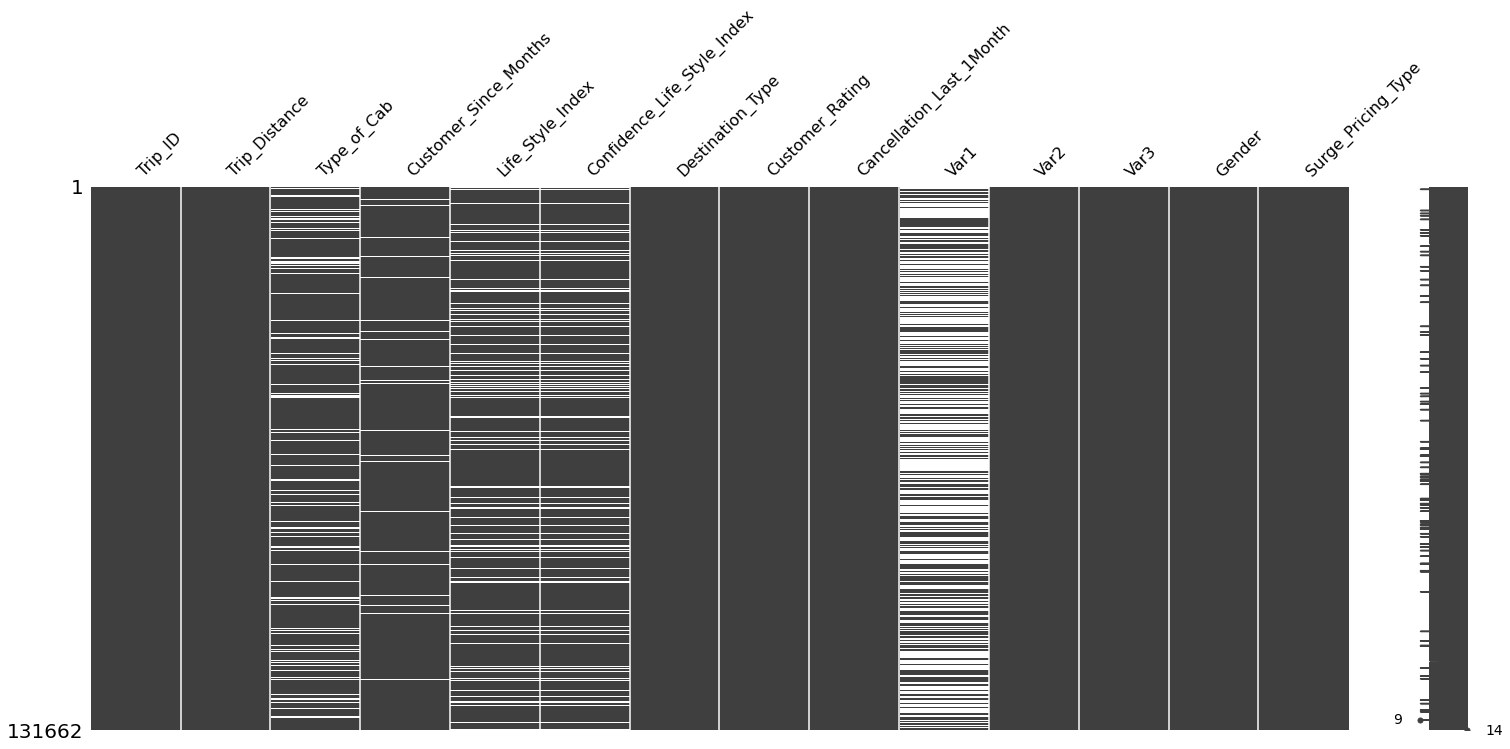

In [7]:
msno.matrix(data)

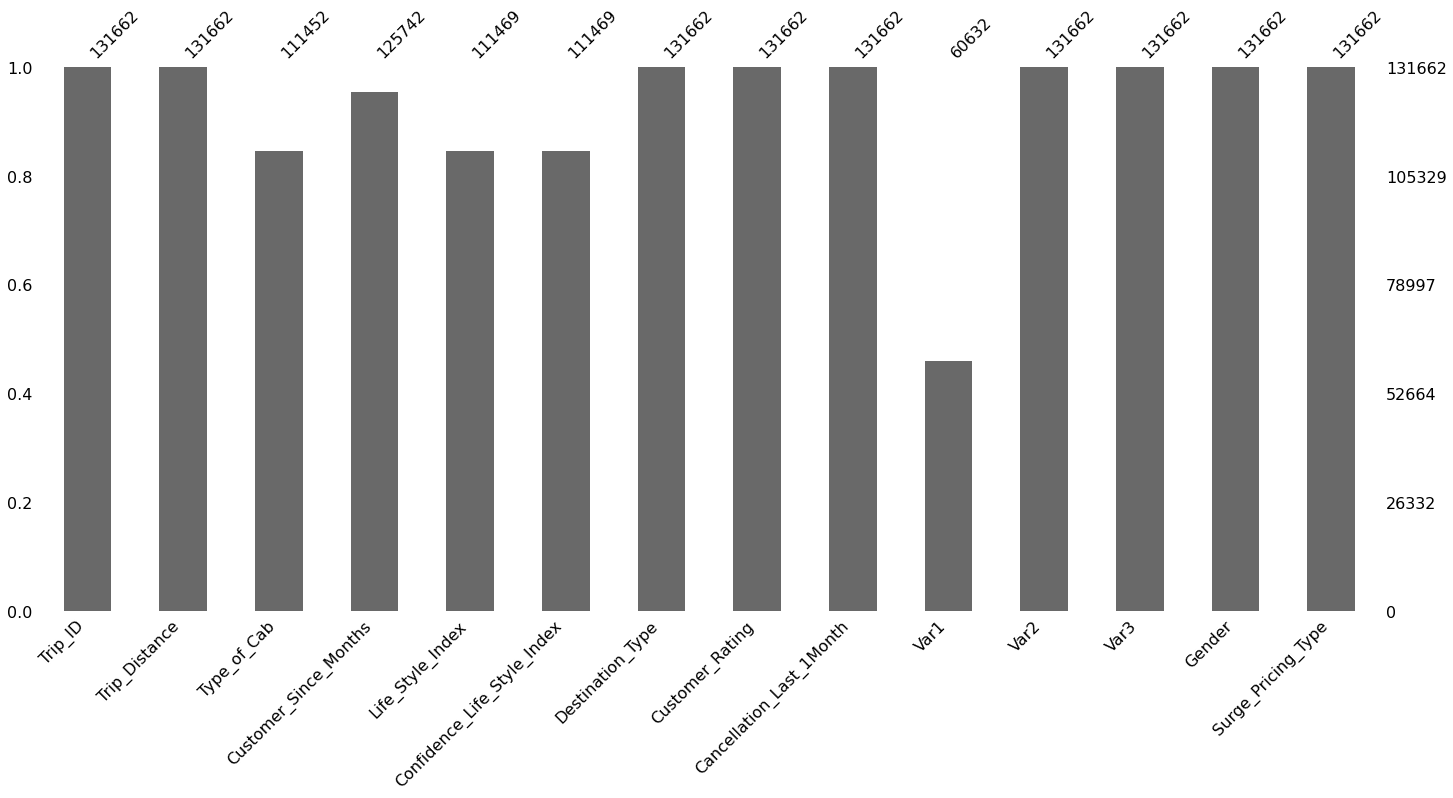

In [8]:
msno.bar(data)

Columns to drop:

1. Trip Id- this is unique for every observation and this doesn't effect our analysis much.

2. Var 1- more than 40% of the column values are null with very low correlation with the surge price

Looking at the correlation heat map to understand the correlation between variables wrt surge pricing.

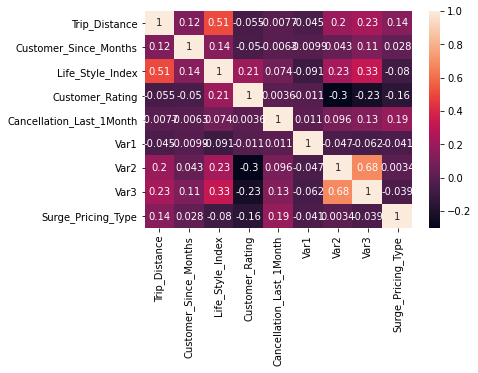

In [9]:
import seaborn as sns

sns.heatmap(data.corr(),annot= True)

In [10]:
#Dropping not needed columns

data.drop(columns=['Trip_ID','Var1'],inplace= True)

In [11]:
data.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var2,Var3,Surge_Pricing_Type
count,131662.000000,125742.000000,111469.000000,131662.000000,131662.000000,131662.000000,131662.000000,131662.000000
mean,44.200909,6.016661,2.802064,2.849458,0.782838,51.202800,75.099019,2.155747
std,25.522882,3.626887,0.225796,0.980675,1.037559,4.986142,11.578278,0.738164
min,0.310000,0.000000,1.596380,0.001250,0.000000,40.000000,52.000000,1.000000
25%,24.580000,3.000000,2.654730,2.152500,0.000000,48.000000,67.000000,2.000000
50%,38.200000,6.000000,2.798050,2.895000,0.000000,50.000000,74.000000,2.000000
75%,60.730000,10.000000,2.946780,3.582500,1.000000,54.000000,82.000000,3.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,124.000000,206.000000,3.000000


Making nan values in  Life style index to 0 to prevent any loss of information.

In [12]:
data['Life_Style_Index']=data['Life_Style_Index'].fillna(0)

In [13]:
#I'll try to understand the lifestyle index better
data['Life_Style_Index'].describe()

count    131662.000000
mean          2.372311
std           1.030863
min           0.000000
25%           2.543860
50%           2.746775
75%           2.912815
max           4.875110
Name: Life_Style_Index, dtype: float64

In [14]:
#To put them as categorical values to understand which lifestyle has most effect in price surge

def lifestyle(x):
  if x>2.9:
     return 'high'
  elif x<=2.9 and x>2:
    return 'medium'
  else:
    return 'low'


In [15]:
data['Life_Style_Category']= data['Life_Style_Index'].apply(lifestyle)

Text(0.5, 1.0, ' Category the Life Style lies in')

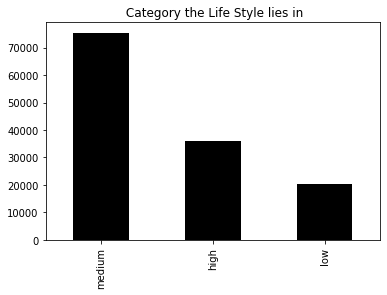

In [42]:
data['Life_Style_Category'].value_counts().plot(kind='bar',color= 'black')

plt.title(' Category the Life Style lies in')

Most of the life style of the customers lie in the medium kind of lifestyle.

Looking for relationship between cancellations and the life style index cateogry column.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_Distance                131662 non-null  float64
 1   Type_of_Cab                  111452 non-null  object 
 2   Customer_Since_Months        125742 non-null  float64
 3   Life_Style_Index             131662 non-null  float64
 4   Confidence_Life_Style_Index  111469 non-null  object 
 5   Destination_Type             131662 non-null  object 
 6   Customer_Rating              131662 non-null  float64
 7   Cancellation_Last_1Month     131662 non-null  int64  
 8   Var2                         131662 non-null  int64  
 9   Var3                         131662 non-null  int64  
 10  Gender                       131662 non-null  object 
 11  Surge_Pricing_Type           131662 non-null  int64  
 12  Life_Style_Category          131662 non-null  object 
dtyp

In [24]:
data['Customer_Since_Months']= data['Customer_Since_Months'].dropna()

Text(0.5, 1.0, 'Customer Since Months')

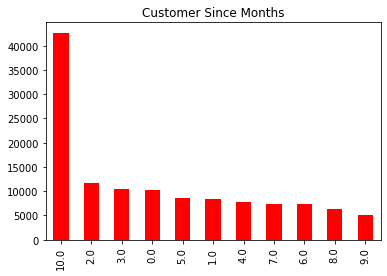

In [40]:
data['Customer_Since_Months'].value_counts().plot(kind='bar',color='red')

plt.title('Customer Since Months')

Most of the customers have been customers for 10 months or more.

Most customers have had a positive experience to have been customer for such a long time.

Text(0.5, 1.0, 'Cancellation in Last 1 Month')

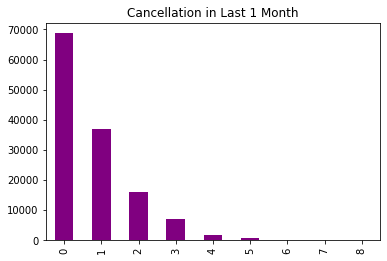

In [41]:
data['Cancellation_Last_1Month'].value_counts().plot(kind='bar',color='purple')

plt.title('Cancellation in Last 1 Month')

Most customers have made 0 or 1 cancellations mostly in the last month.

Looking for nan values in the type of cab column.

In [28]:
data['Type_of_Cab'].isnull().sum()

20210

In [29]:
data['Type_of_Cab'].value_counts()

B    31136
C    28122
A    21569
D    18991
E    11634
Name: Type_of_Cab, dtype: int64

Filling the nan values with cab type F to avoid losing important inforamtion on the data.

In [30]:
data['Type_of_Cab']= data['Type_of_Cab'].fillna('F')

In [31]:
data['Type_of_Cab'].value_counts()

B    31136
C    28122
A    21569
F    20210
D    18991
E    11634
Name: Type_of_Cab, dtype: int64

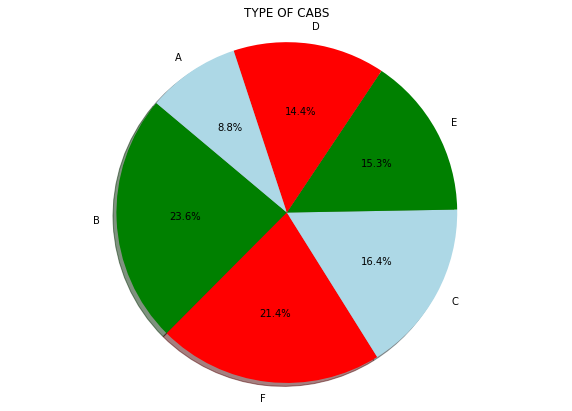

In [48]:
# Data to plot (#Final code for pie chart)
labels = data['Type_of_Cab'].unique()
sizes = data['Type_of_Cab'].value_counts()
colors = ['green', 'red', 'lightblue']

# Plot
fig = plt.figure(figsize =(10, 7))
plt.pie(sizes,labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('TYPE OF CABS')
plt.show()

If we understand this pie chart-

1. The most popular types of cabs are B,C and E

2. Around 20% of the Customers have not entered the cab type, but due to loss of information we cannot risk removing these observations either.